<a href="https://colab.research.google.com/github/SIVANESAN2061/dig_aud_reg_CNN/blob/main/title_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import librosa
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools

# Set paths to input and output data
INPUT_DIR = '/content/drive/MyDrive/PROJECT/rec/recordings'
OUTPUT_DIR = '/content/drive/MyDrive/PROJECT/rec/working'

# Print names of 10 WAV files from the input path
parent_list = os.listdir(INPUT_DIR)
for i in range(10):
    print(parent_list[i])

6_theo_27.wav
6_theo_16.wav
6_nicolas_6.wav
6_nicolas_47.wav
6_theo_22.wav
6_nicolas_9.wav
6_theo_11.wav
6_nicolas_5.wav
6_theo_10.wav
6_theo_29.wav


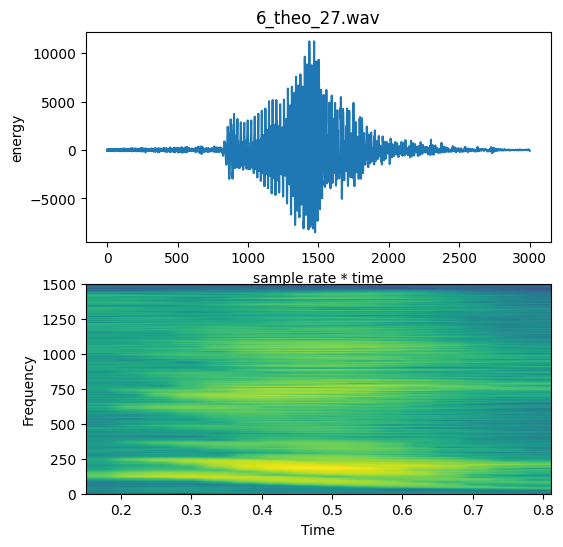

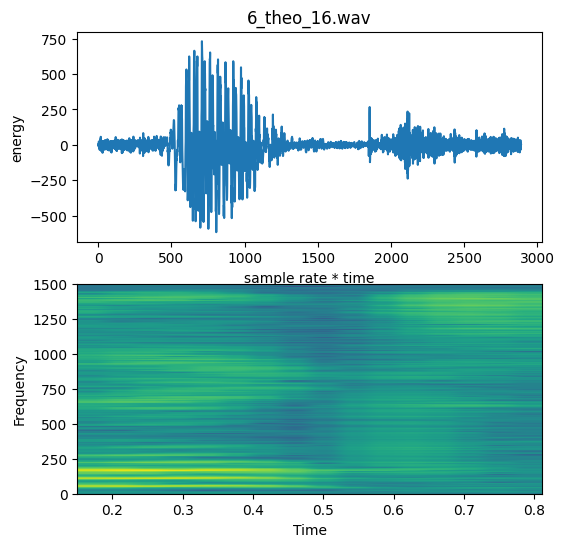

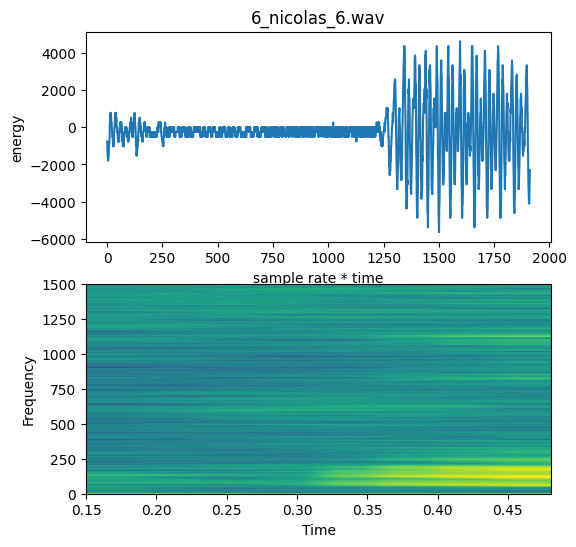

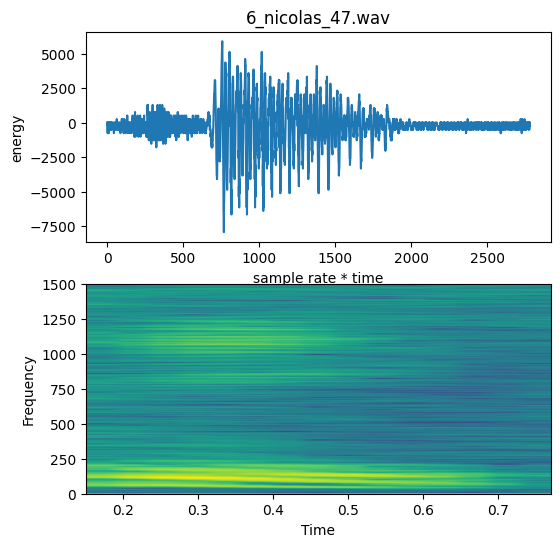

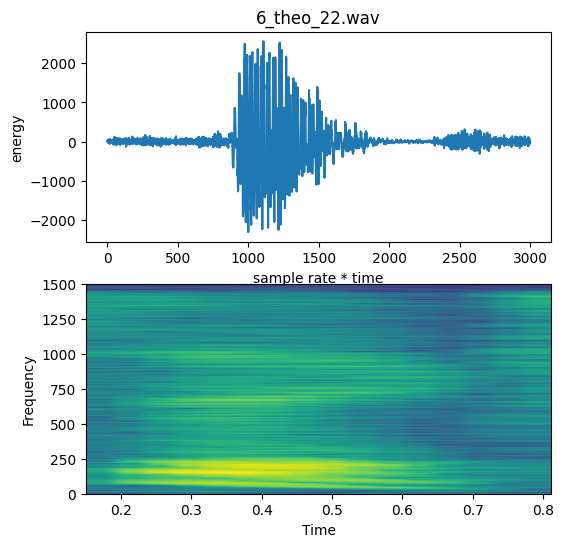

In [ ]:
for i in range(5):
    signal_wave = wave.open(os.path.join(INPUT_DIR, parent_list[i]), 'r')
    sample_rate = 3000
    sig = np.frombuffer(signal_wave.readframes(sample_rate), dtype=np.int16)

    plt.figure(figsize=(6,6))
    plot_a = plt.subplot(211)
    plot_a.set_title(parent_list[i])
    plot_a.plot(sig)
    plot_a.set_xlabel('sample rate * time')
    plot_a.set_ylabel('energy')

    plot_b = plt.subplot(212)
    plot_b.specgram(sig, NFFT=1024, Fs=sample_rate, noverlap=900)
    plot_b.set_xlabel('Time')
    plot_b.set_ylabel('Frequency')

plt.show()


In [ ]:
# Utility function to get sound and frame rate info
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate
OUTPUT_DIR = str(OUTPUT_DIR)
# For every recording, make a spectogram and save it as label_speaker_no.png
if not os.path.exists(os.path.join(OUTPUT_DIR, 'audio-images')):
    os.mkdir(os.path.join(OUTPUT_DIR, 'audio-images'))

for filename in os.listdir(INPUT_DIR):
    if "wav" in filename:
        file_path = os.path.join(INPUT_DIR, filename)
        file_stem = Path(file_path).stem
        target_dir = f'class_{file_stem[0]}'
        dist_dir = os.path.join(os.path.join(OUTPUT_DIR, 'audio-images'), target_dir)
        file_dist_path = os.path.join(dist_dir, file_stem)
        if not os.path.exists(file_dist_path + '.png'):
            if not os.path.exists(dist_dir):
                os.mkdir(dist_dir)
            file_stem = Path(file_path).stem
            sound_info, frame_rate = get_wav_info(file_path)
            pylab.specgram(sound_info, Fs=frame_rate)
            pylab.savefig(f'{file_dist_path}.png')
            pylab.close()

# Print the ten classes in our dataset
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images'))
print("Classes: \n")
for i in range(10):
    print(path_list[i])

# File names for class 1
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images/class_1'))
print("\nA few example files: \n")
for i in range(10):
    print(path_list[i])

Classes: 

class_6
class_7
class_8
class_9
class_3
class_4
class_5
class_0
class_1
class_2

A few example files: 

1_george_11.png
1_george_2.png
1_george_1.png
1_george_21.png
1_george_20.png
1_george_10.png
1_george_15.png
1_george_22.png
1_george_3.png
1_george_28.png


In [ ]:
# Declare constants
IMAGE_HEIGHT = 100
IMAGE_WIDTH = 64
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

Found 3020 files belonging to 10 classes.
Using 2416 files for training.
Found 3020 files belonging to 10 classes.
Using 604 files for validation.


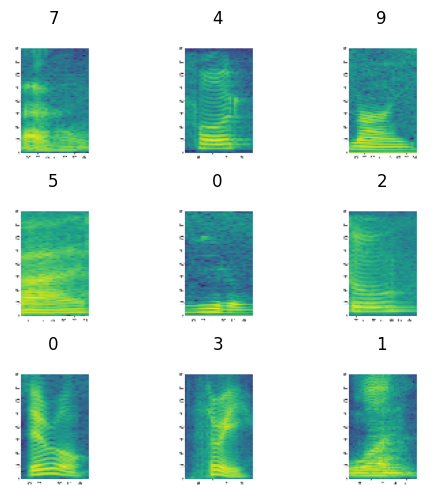

In [ ]:
plt.figure(figsize=(6, 6))
for images, labels in train_dataset.take(3):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

In [ ]:
# Function to prepare our datasets for modelling
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])

    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model

# Define the VGG19 model with pre-trained weights (include_top=False for feature extraction)
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the pre-trained VGG19 base
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(N_CLASSES, activation='softmax')(x)

# Create the final VGG19 model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy']
)

# Train the model for 10 epochs and capture the history
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)




80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/10
76/76 [==============================] - 413s 5s/step - loss: 1.0037 - accuracy: 0.6929 - val_loss: 2.4736 - val_accuracy: 0.2070
Epoch 2/10
76/76 [==============================] - 334s 4s/step - loss: 0.4856 - accuracy: 0.8671 - val_loss: 2.5512 - val_accuracy: 0.1904
Epoch 3/10
76/76 [==============================] - 337s 4s/step - loss: 0.3752 - accuracy: 0.9027 - val_loss: 2.0022 - val_accuracy: 0.4056
Epoch 4/10
76/76 [==============================] - 335s 4s/step - loss: 0.3205 - accuracy: 0.9205 - val_loss: 4.2526 - val_accuracy: 0.1407
Epoch 5/10
76/76 [==============================] - 336s 4s/step - loss: 0.2593 - accuracy: 0.9350 - val_loss: 2.0083 - val_accuracy: 0.4089
Epoch 6/10
76/76 [==============================] - 336s 4s/step - loss: 0.2296 - accuracy: 0.9429 - val_loss: 3.0748 - val_accuracy: 0.3874
Epoch 7/10
76/76 [==============================] - 336s 4s/step - loss: 0.2050 - accurac

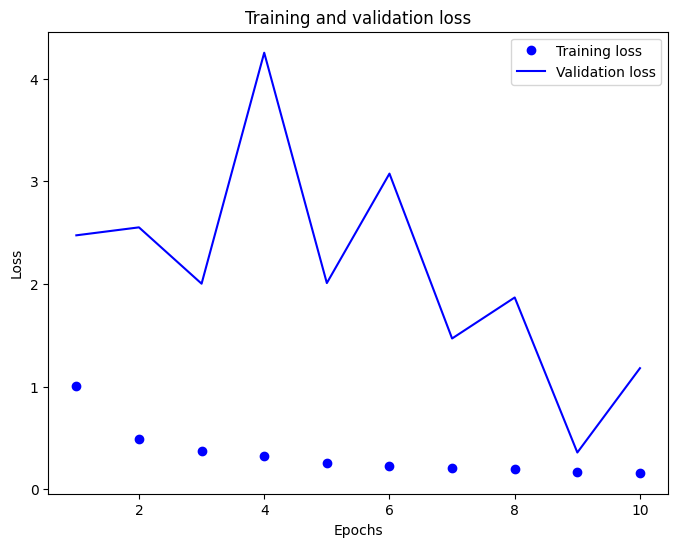

In [ ]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

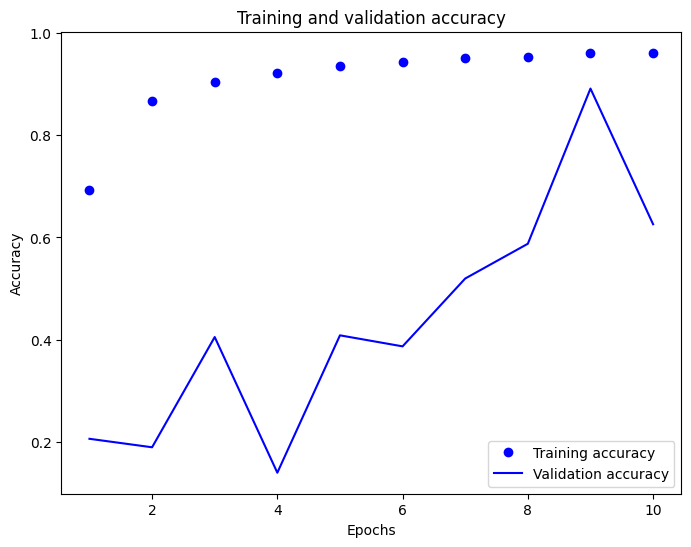

In [ ]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 1.179072, final accuracy: 0.625828
